In [1]:
import sympy as sp
import festim as F
import numpy as np
import scipy.constants as const
import numpy as np 
import matplotlib.pyplot as plt

my_model = F.Simulation()
N_A_const=const.N_A

vertices = np.concatenate([
    np.linspace(0, 30e-9, num=600),
    np.linspace(30e-9, 3e-6, num=300),
    np.linspace(3e-6, 5e-4, num=200),
])

my_model.mesh = F.MeshFromVertices(vertices)
tungsten = F.Material(
    id=1,
    D_0=1.9e-07/(2)**0.5,  # m2/s
    E_D=0.2,  # eV
)

my_model.materials = tungsten
implantation_time = 4000  # s

ion_flux = sp.Piecewise((1.25e19, F.t <= implantation_time), (0, True))
w_atom_density = 6.338e28  # atom/m3
R_imp=4.216E-9

trap_1 = F.Trap(
        k_0=1E13/6/w_atom_density,
        E_k=0.2,
        p_0=1e13,
        E_p=0.834,
        density=1.364e-3*w_atom_density,
        materials=tungsten
    )
trap_2 = F.Trap(
        k_0=1E13/6/w_atom_density,
        E_k=0.2,
        p_0=1e13,
        E_p=0.959,
        density=3.639e-4*w_atom_density,
        materials=tungsten
    )

center = 10e-9
width = 2e-9
distribution = 1/(1+sp.exp((F.x-center)/width))
trap_3 = F.Trap(
        k_0=1E13/6/w_atom_density,
        E_k=0.2,
        p_0=1e13,
        E_p=1.496,
        density=9.742E-2*w_atom_density*distribution ,
        materials=tungsten
    )
my_model.traps = [trap_1, trap_2, trap_3]

implantation_temp = 300  # K
temperature_ramp = 8  # K/s

start_tds = implantation_time + 990  # s

my_model.T = F.Temperature(
    value=sp.Piecewise(
        (implantation_temp, F.t < start_tds),
        (implantation_temp + temperature_ramp*(F.t-start_tds), True))
)

my_model.boundary_conditions = [
    F.DirichletBC(surfaces=[2], value=0, field=0),
    F.DirichletBC(surfaces=[1],value=sp.Piecewise((R_imp*ion_flux/(1.9e-07/(2)**0.5*np.exp(-0.2/(8.617333262e-05*implantation_temp))), F.t <= implantation_time), (0, True)), field=0)
]
my_model.dt = F.Stepsize(
    initial_value=0.001,
    stepsize_change_ratio=1.1,
    t_stop=10,
    stepsize_stop_max=0.5,
    dt_min=1e-08
)
my_model.settings = F.Settings(
    absolute_tolerance=1e10,
    relative_tolerance=1e-5,
    final_time=start_tds+100
)
list_of_derived_quantities = [
        F.TotalVolume("solute", volume=1),
        F.TotalVolume("retention", volume=1),
        F.TotalVolume("1", volume=1),
        F.TotalVolume("2", volume=1),
        F.TotalVolume("3", volume=1),
        F.HydrogenFlux(surface=1),
        F.HydrogenFlux(surface=2),
        F.AverageVolume("T",volume=1)
    ]

derived_quantities = F.DerivedQuantities(
    list_of_derived_quantities
)


my_model.exports = [derived_quantities]

In [2]:
import os
current_working_directory = os.getcwd()
if current_working_directory.endswith("Festim_models/Jupyter_notebooks"):
    os.chdir('../../graph_scripts_and_results/TDS')
else:
    os.chdir('graph_scripts_and_results/TDS')
my_model.initialise()
my_model.run()

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        5.1e+03 s    Ellapsed time so far: 301.8 s


In [3]:
t = derived_quantities.t
flux_left = derived_quantities.filter(fields="solute", surfaces=1).data
flux_right = derived_quantities.filter(fields="solute", surfaces=2).data
T = derived_quantities.filter(fields="T", volumes=1).data
flux_total = -np.array(flux_left) - np.array(flux_right)

Text(0.5, 0, 'Time (s)')

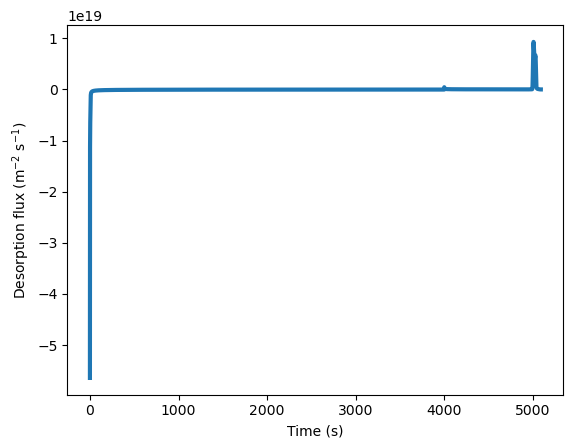

In [4]:

plt.plot(t, flux_total, linewidth=3)

plt.ylabel(r"Desorption flux (m$^{-2}$ s$^{-1}$)")
plt.xlabel(r"Time (s)")

In [5]:
trap_1 = derived_quantities.filter(fields="1").data
trap_2 = derived_quantities.filter(fields="2").data
trap_3 = derived_quantities.filter(fields="3").data

contribution_trap_1 = -np.diff(trap_1)/np.diff(t)
contribution_trap_2 = -np.diff(trap_2)/np.diff(t)
contribution_trap_3 = -np.diff(trap_3)/np.diff(t)

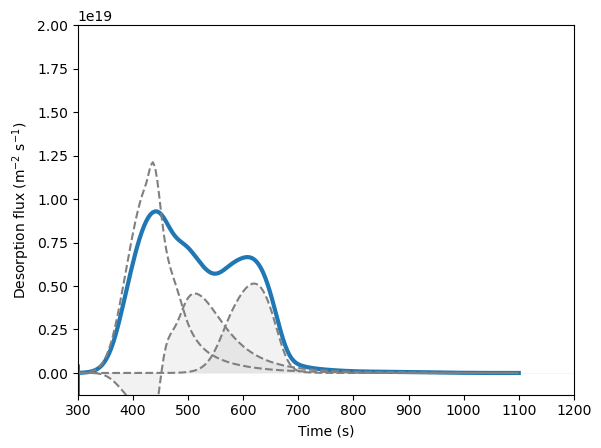

In [6]:
plt.plot(T, flux_total, linewidth=3)
plt.plot(T[1:], contribution_trap_1, linestyle="--", color="grey")
plt.fill_between(t[1:], 0, contribution_trap_1, facecolor='grey', alpha=0.1)
plt.plot(T[1:], contribution_trap_2, linestyle="--", color="grey")
plt.fill_between(T[1:], 0, contribution_trap_2, facecolor='grey', alpha=0.1)
plt.plot(T[1:], contribution_trap_3, linestyle="--", color="grey")
plt.fill_between(T[1:], 0, contribution_trap_3, facecolor='grey', alpha=0.1)

plt.xlim(300, 1200)
plt.ylim(bottom=-1.25e18, top=0.2e20)
plt.ylabel(r"Desorption flux (m$^{-2}$ s$^{-1}$)")
plt.xlabel(r"Time (s)")

plt.ylabel(r"Desorption flux (m$^{-2}$ s$^{-1}$)")
plt.xlabel(r"Time (s)")

np.savetxt('TDS_W.txt',np.column_stack([T,np.abs(flux_total)]))